In [1]:
# Import the usual stuff
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Sequence, Tuple

# Path to harmonic oscillator modules
import sys
import os
module_path=os.path.abspath('/Users/zentner/Work/PhysicsModels/schrodinger1d')
if module_path not in sys.path:
    sys.path.append(module_path)

import schrodinger_solver_1d as sch
import potentials_1d as pot
import wavefunctions as psi
import find_eigen_functions as eigen

In [2]:
#----- cosine potential
v0 = -2.0
v_cos = pot.CosinePotential(V0=v0)

In [3]:
#---- make my periodic grid ---
def make_periodic_grid(Ncells,Nppc,a=1.0) -> tuple[sch.Grid1D, float]:
    """
    make a periodic grid for periodic problems.
    """
    N = Ncells*Nppc # total number of points in the computational domain
    L = Ncells*a    # length of the computational domain.
    y_max = L/2.0
    return sch.make_grid(N,y_max), L

N_cells = 2**4 # number of unit cells
N_ppc = 2**8 # number of modeling points per unit cell
a = 1.0 # periodicity

grid_test, L_test = make_periodic_grid(N_cells, N_ppc)

In [4]:
# --- lastly, let's try to find the first few excited states in addition ---
# --- it needs an energy function
def energy_fn(psi):
    return sch.expectation_H(psi=psi, grid=grid_test, V_of_y_tau=v_cos, bc="fft")["H"]

#--- give bloch quasi-momenta in first Brillouin Zone
m_values = eigen.make_m_list_first_bz(grid_test,a=1.0) # periodicity is set to 1.0
n_bands = 3

#--- guesses
def make_bloch_guess_from_free_particle(
    *,
    grid,
    m_list: Sequence[int],
    n_bands: int,
    noise_level: float = 0.05,
    seed: int = 0,
) -> Dict[Tuple[int, int], np.ndarray]:
    """
    Build psi_guesses dict for periodic Bloch-sector eigenfinder
    using your free_particle() function.

    Keys are (m, band).

    Parameters
    ----------
    grid : object with attributes y and dy
    m_list : list of Bloch sector indices
    n_bands : number of bands per sector
    noise_level : amplitude of complex noise added to guesses
    seed : RNG seed for reproducibility
    """

    rng = np.random.default_rng(seed)

    y = grid.y
    Ny = y.size
    L = Ny * grid.dy

    psi_guesses: Dict[Tuple[int, int], np.ndarray] = {}

    for m in m_list:
        # Free particle plane wave in this Bloch sector
        base = psi.free_particle(y, n=m, L=L)

        for band in range(n_bands):

            if band == 0:
                # lowest band guess: pure plane wave + small noise
                noise = noise_level * (
                    rng.normal(size=Ny) + 1j * rng.normal(size=Ny)
                )
                psi0 = base + noise

            else:
                # higher bands: bias toward slightly higher Fourier content
                # n = m + band shifts momentum slightly
                base_shifted = psi.free_particle(y, n=m + band, L=L)
                noise = noise_level * (
                    rng.normal(size=Ny) + 1j * rng.normal(size=Ny)
                )
                psi0 = base_shifted + noise

            psi_guesses[(m, band)] = psi0.astype(np.complex128)

    return psi_guesses

#--- build guesses
psi_guesses = make_bloch_guess_from_free_particle(grid=grid_test,
                                                  m_list=m_values,
                                                  n_bands=n_bands)
    

#--- find the first few states
res = eigen.find_bloch_states(n_bands = n_bands,
                              m_list = m_values,
                              grid = grid_test,
                              V_of_y = v_cos,
                              energy_fn = energy_fn,
                              a=1.0,
                              psi_guesses=psi_guesses)

psis = res["psis"]
energies = res["energies"]
k_vals = res["k_vals"]

In [26]:
#--- enforce band tracking
k_bz = eigen.wrap_to_first_bz(k_vals, a=a)          # in [-pi/a, pi/a)

# UNWRAP to [0, 2pi/a) so -pi maps to +pi
k_unwrap = np.mod(k_bz, 2.0*np.pi/a)                # in [0, 2pi/a)

idx = np.argsort(k_unwrap)                          # now order is 0 -> 2pi smoothly

k_track = k_bz[idx]                                 # keep the wrapped value for plotting if you want
psis_sort = [psis[i] for i in idx]
E_sort = energies[idx, :]

psis_tr, E_tr, perm = eigen.track_bands_by_overlap(psis_sort, E_sort, dy=grid_test.dy, nbands=n_bands)

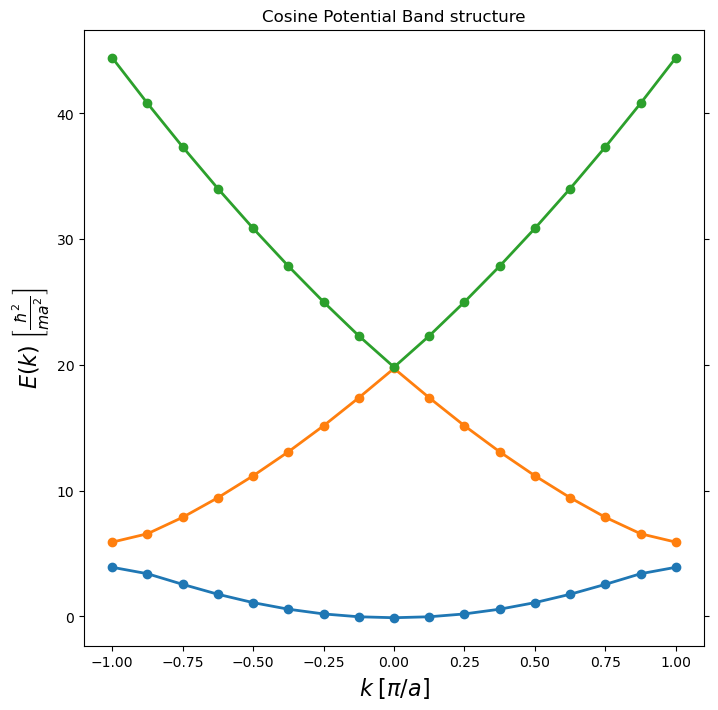

In [37]:
#--- let's plot a band diagram
#
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.tick_params(right=True)
#

# sort by k so the lines connect in order
k_plot = k_bz

idx = np.argsort(k_plot)
k_sorted = k_plot[idx]/(np.pi/a)
E_sorted = energies[idx, :]

k_sorted = np.concatenate([k_sorted,[1.0]])
E_sorted = np.vstack([E_sorted, E_sorted[0, :]])

for band in range(E_sorted.shape[1]):
    plt.plot(k_sorted, E_sorted[:, band], marker="o", linewidth=2.0)
    
plt.xlabel(r"$k\; \left[ \pi/a \right]$",fontsize=16)
plt.ylabel(r"$E(k) \; \left[ \frac{\hbar^2}{m a^2} \right]$",fontsize=16)

plt.title("Cosine Potential Band structure")

plt.show()

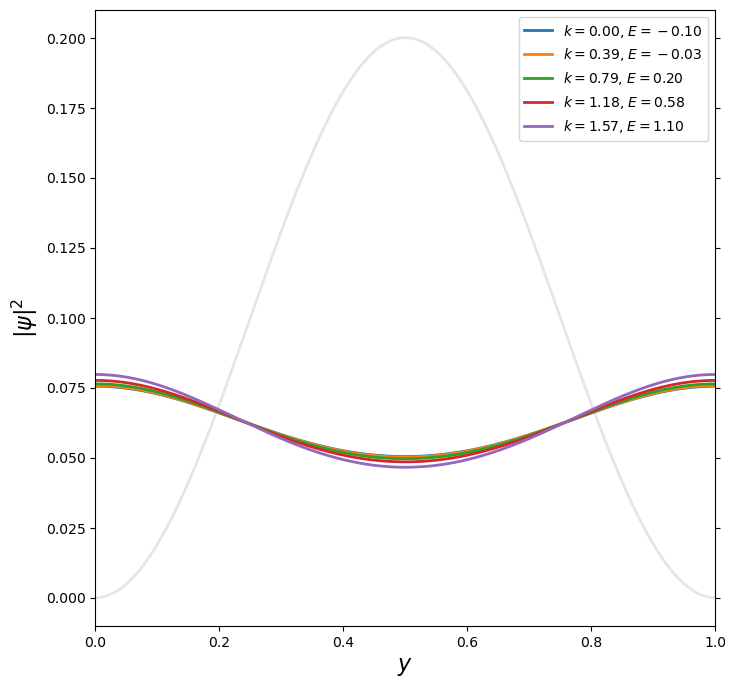

In [40]:
#Plot |psi|^2 #
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.tick_params(right=True)

v=v_cos(grid_test.y,0.0)+np.abs(v0)

plt.plot(grid_test.y,v/20.0,linewidth=2.0,color='black',alpha=0.1)

band = 0

for ik in range(5):
    plt.plot(grid_test.y, np.abs(psis_tr[ik][band])**2, linewidth=2.0, label=rf'$k = {np.abs(k_track[ik]):.2f}$, $E = {E_tr[ik,band]:.2f}$')

plt.xlabel(r"$y$",fontsize=16)
plt.ylabel(r"$\vert \psi \vert^2$",fontsize=16)
#plt.figure(figsize=(20,20))
fig.set_facecolor("white")

plt.xlim(0.0,1.0)
#plt.ylim(0.05,0.08)

plt.legend()
#plt.savefig('psi_band2.png')
plt.show()

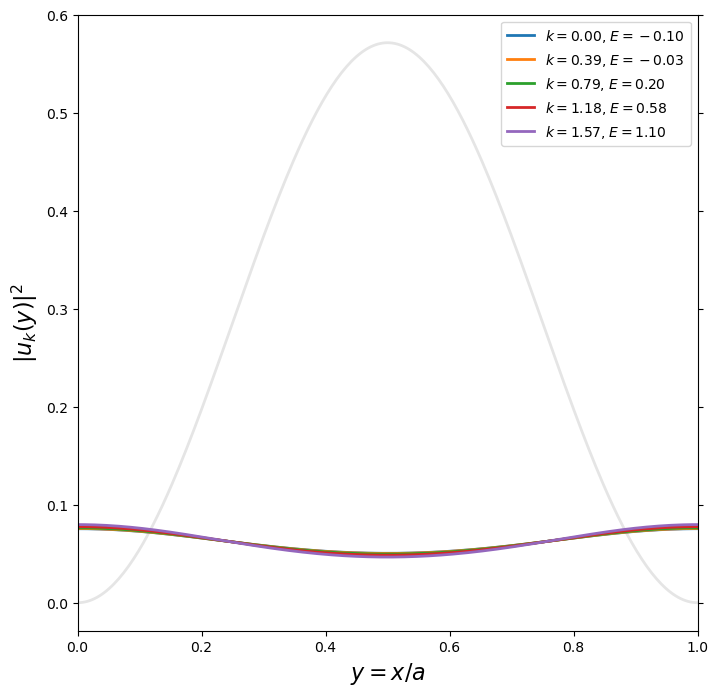

In [35]:
#Plot u_k(y) #
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.tick_params(right=True)

v=v_cos(grid_test.y,0.0)+np.abs(v0)

plt.plot(grid_test.y,v/7.0,linewidth=2.0,color='black',alpha=0.1)

band = 0

for ik in range(5):
    u = np.exp(1.0j*k_track[ik]*grid_test.y)*psis_tr[ik][band] # should give u_k(y)
    j0 = np.argmax(u)
    u *= np.exp(-1.0j*np.angle(u[j0]))
    plt.plot(grid_test.y, np.abs(u)**2, linewidth=2.0, label=rf'$k = {np.abs(k_track[ik]):.2f}$, $E = {E_tr[ik,band]:.2f}$')

plt.xlabel(r"$y=x/a$",fontsize=16)
plt.ylabel(r"$\vert u_{k}(y) \vert^2$",fontsize=16)
#plt.figure(figsize=(20,20))
fig.set_facecolor("white")

plt.xlim(0.0,1.0)
#plt.ylim(0.22,0.28)

plt.legend()
plt.savefig('u_k_band1.png')
plt.show()

In [ ]:
dy = grid_test.dy
a = 1.0
shift = int(round(a/dy))

for ik in range(1,5):
    psi_k = psis[ik][0]

    # eigenvalue for translation by +a (roll -shift)
    lam_plus = np.vdot(psi_k, np.roll(psi_k, -shift))*dy / (np.vdot(psi_k, psi_k)*dy)

    # eigenvalue for translation by -a (roll +shift)
    lam_minus = np.vdot(psi_k, np.roll(psi_k, +shift))*dy / (np.vdot(psi_k, psi_k)*dy)

    print(ik, "k=",k_vals[ik], "lam(+a)=",lam_plus, "lam(-a)=",lam_minus)